In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import timedelta
from datetime import datetime

import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

import scipy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
print('pandas version :', pd.__version__, '\n')
print('numpy version :', np.__version__, '\n')
print('matplotlib version :', matplotlib.__version__, '\n')
print('seaborn version :', sns.__version__, '\n')
print('sklearn version :', sklearn.__version__, '\n')
print('scipy version :', scipy.__version__, '\n')
print('yellowbrick version : ', yellowbrick.__version__)

pandas version : 1.2.4 

numpy version : 1.19.5 

matplotlib version : 3.3.4 

seaborn version : 0.11.2 

sklearn version : 1.0.2 

scipy version : 1.6.2 

yellowbrick version :  1.3.post1


# Fonctions

In [4]:
# Par défaut, on va se placer 6 mois avant la dernière commande
def choix_df(data, date_debut=date(2016, 9, 4),
             date_fin=date(2018, 3, 3)):
    """
    Prend un Dataframe qui va être filtrer selon la date de début
    et la date de fin indiquées en paramètres. Les colonnes du
    dataframe seront groupées selon certaines fonctions (moyenne,
    somme, compter et minimum). Enfin, ajoute une colonne
    correspondant à la fréquence d'achat d'un client sur la
    période étudiée.

            Parameters:
                data : dataframe à utiliser
                date_debut (date object) : date de début du filtrage
                date_fin (date object) : date de fin du filtrage
    """
    data = df0.copy()

    # On commence par ne garder que la période qui nous intéresse
    data = data[(data['order_purchase_timestamp'] >= date_debut)
                & (data['order_purchase_timestamp'] <= date_fin)]

    # Date de la dernière commande du jeu de données
    jour_max = data['order_purchase_timestamp'].max()

    # Date de la première commande du jeu de données
    jour_min = data['order_purchase_timestamp'].min()

    # Nombre de jour au total
    nb_jours = (jour_max - jour_min).days

    # Temps entre la commande du client et la dernière date du jeu de données
    data['time_delta'] = (data['order_purchase_timestamp'].max()
                          - data['order_purchase_timestamp'])

    # On transforme "time_delta" pour n'avoir que les jours en nombres entiers
    data['time_delta'] = data['time_delta'].dt.days

    # On crée les colonnes que l'on veut
    data = (data.groupby('customer_unique_id').agg(
        nb_commandes=('order_id', 'count'), score_moy=('review_score',
                                                       'mean'),
        nb_paiements=('payment_installments', 'mean'),
        nb_produits=('order_item_id', 'mean'),
        recence=('time_delta', 'min'),
        montant_total=('order_total_cost', 'sum')))

    # On veut des nombres entiers pour certaines colonnes
    for col in ['score_moy', 'nb_paiements', 'nb_produits']:
        data[col] = data[col].astype(int)

    # On crée une colonne de fréquence d'achat
    data['frequence_achat'] = round(data['nb_commandes'] / nb_jours, 4)

    return(data)

In [5]:
# Preprocessing
def preprocessing(data):
    """
    Prend un DataFrame et passe les colonnes les plus concentrées sur des
    faibles valeurs au logarithme. Prend ensuite toutes les features numériques
    pour les centrer (on soustrait la moyenne de la feature) et les réduire
    (diviser par l'écart-type de la feature) à l'aide d'un StandardScaler.

            Parameters:
                data : DataFrame à utiliser
    """
    # On passe quelques colonnes au log
    transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)

    cols_to_log = ['nb_commandes', 'nb_paiements', 'nb_produits',
                   'montant_total', 'frequence_achat']

    for col in cols_to_log:
        data[col] = transformer.fit_transform(data[col])

    # On standardise nos colonnes
    cols_to_scale = ['nb_commandes', 'score_moy', 'nb_paiements',
                     'nb_produits', 'recence', 'montant_total',
                     'frequence_achat']

    scaler = StandardScaler()

    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [6]:
# Elbow plot
def elbow_k_means(data):
    """
    Prend un Dataframe et lui applique un algorithme de clustering
    (k means) pour différents nombres de cluster (entre 2 et 9) et
    retourne le temps mis pour appliquer chacun des modèles à nos
    données ainsi que la valeur de distortion de chaque clustering sous
    la forme de graphique.
    La valeur de distortion correspond à la somme des distances au carré
    entre un point et le centre de son cluster. Le point d'inflexion
    de la courbe sera indiqué (si existant).

            Parameters:
                data : DataFrame à utiliser
    """
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 10))

    visualizer.fit(data)
    visualizer.show()

In [7]:
# Silhouette plot
def silhouette_k_means(data, model):
    """
    Prend un Dataframe et lui applique l'algorithme de clustering
    k-means souhaité. Calcule la densité de chaque cluster (comprise
    entre -1 et 1) en utilisant la coefficient de silhouette de chaque
    échantillon. Ce coefficient est la différence entre la distance
    moyenne intra-cluster et la distance moyenne avec le cluster
    le plus proche pour chaque échantillon, le tout normalisé par la
    valeur maximale.

            Parameters:
                data : DataFrame à utiliser
                model : modèle de clustering à appliquer
    """
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(data)
    visualizer.show()

# Preprocessing initial

In [8]:
# On charge notre jeu de données
df0 = pd.read_csv('P5_01_frequence.csv')
df0 = df0.drop(columns=['Unnamed: 0'])
print("Nombre de lignes de df0 :", df0.shape[0])

Nombre de lignes de df0 : 98665


In [9]:
# On transforme notre colonne de date en datetime
df0['order_purchase_timestamp'] = pd.to_datetime(
    df0['order_purchase_timestamp'], format='%Y-%m-%d')

# On enlève les heures - minutes - secondes, on ne garde que la date
df0['order_purchase_timestamp'] = df0['order_purchase_timestamp'].dt.date

In [10]:
# On prend 1 an et demi de données
df_ini = choix_df(df0)
print("Nombre de lignes de df_ini :", df_ini.shape[0])

Nombre de lignes de df_ini : 57656


In [11]:
# On vérifie le typage de nos données
df_ini.dtypes

nb_commandes         int64
score_moy            int32
nb_paiements         int32
nb_produits          int32
recence              int64
montant_total      float64
frequence_achat    float64
dtype: object

In [12]:
# Et les premières lignes
df_ini.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,3,8,1,358,86.22,0.0018
0000f6ccb0745a6a4b88665a16c9f078,1,4,4,1,142,43.62,0.0018
0004aac84e0df4da2b147fca70cf8255,1,5,6,1,109,196.89,0.0018


In [13]:
# On garde une copie de nos données
df = df_ini.copy()

# Preprocessing de nos données
preprocessing(df_ini)

df_ini.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,-0.172036,-0.790676,1.655709,-0.307924,1.754817,-0.320600,-0.172362
0000f6ccb0745a6a4b88665a16c9f078,-0.172036,-0.045677,0.800601,-0.307924,-0.146589,-1.134669,-0.172362
0004aac84e0df4da2b147fca70cf8255,-0.172036,0.699322,1.300807,-0.307924,-0.437081,0.665935,-0.172362


In [14]:
# On vérifie que la copie fonctionne
df.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,3,8,1,358,86.22,0.0018
0000f6ccb0745a6a4b88665a16c9f078,1,4,4,1,142,43.62,0.0018
0004aac84e0df4da2b147fca70cf8255,1,5,6,1,109,196.89,0.0018


# RFM

On commence par regarder les variables RFM (Récence, Fréquence, Montant) afin de regrouper nos clients.

## RFM - KMeans

Premier algorithme de clustering à essayer : K-Means.

In [15]:
df_rfm = df_ini[['recence', 'frequence_achat', 'montant_total']]

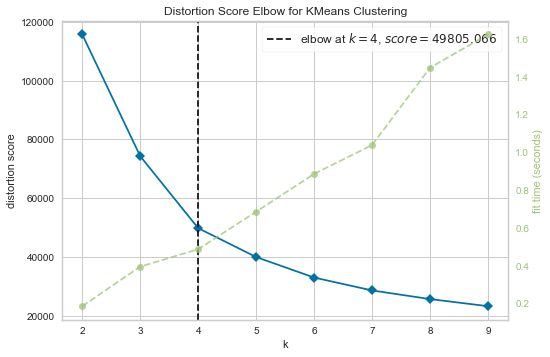

In [16]:
# Elbow plot pour déterminer le nombre optimal de cluster
elbow_k_means(df_rfm)

In [17]:
# On utilise notre valeur optimale de k
k_means_rfm = KMeans(n_clusters=4, init='k-means++',  random_state=24)
y = k_means_rfm.fit_predict(df_rfm.values)

# On regarde nos clusters
df['cluster'] = y
df['cluster'].value_counts()

3    22269
1    17618
0    16048
2     1721
Name: cluster, dtype: int64

Regardons à quoi correspond ce cluster de 1721 individus. 

In [18]:
frequences = df['frequence_achat'].value_counts()

print('Nombre total de chacune de nos frequences :')
print(frequences, '\n')

print("Nombre total de commandes avec plus d'une commande :",
      frequences.iloc[1:].sum())

Nombre total de chacune de nos frequences :
0.0018    55935
0.0037     1590
0.0055      106
0.0073       15
0.0092        4
0.0110        3
0.0165        2
0.0128        1
Name: frequence_achat, dtype: int64 

Nombre total de commandes avec plus d'une commande : 1721


Un de nos 4 clusters est donc uniquement composé des individus qui ont fait plus d'une commande sur notre période de 2 ans.

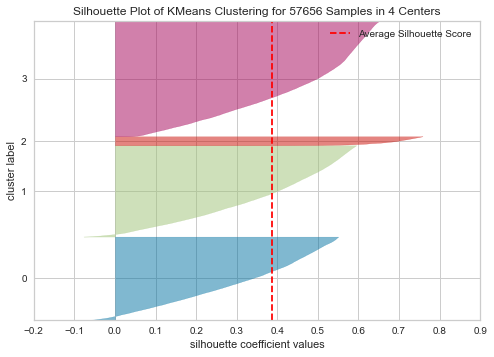

In [19]:
# Silhouette plot
silhouette_k_means(df_rfm.values, model=k_means_rfm)

Regardons visuellement nos clusters :

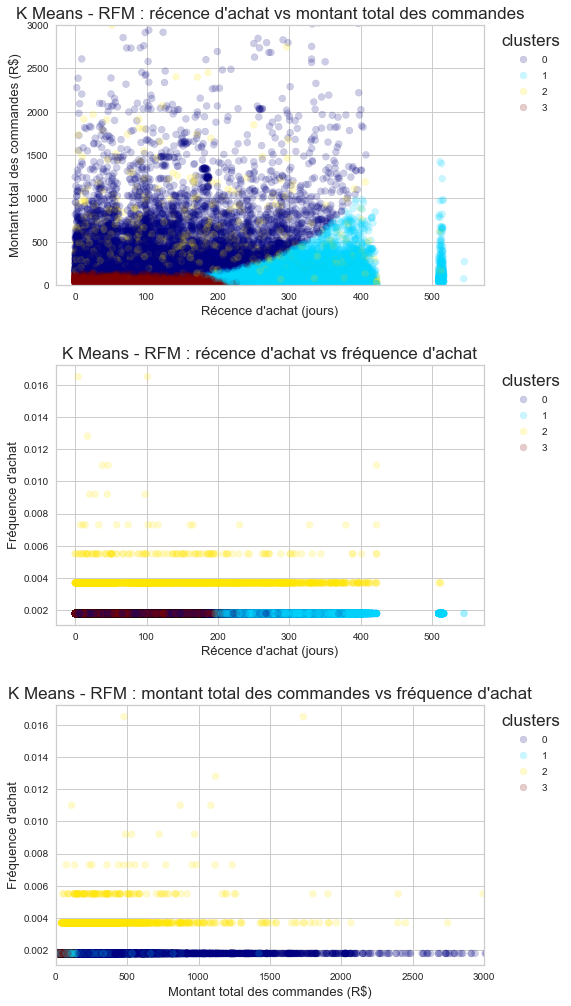

In [20]:
clusters_rfm = k_means_rfm.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "K Means - RFM : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)

fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_rfm, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "K Means - RFM : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)

fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_rfm, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: montant_total, Y: frequence_achat
ax[2].set_xlim(0, 3000)
ax[2].set_title(
    "K Means - RFM : montant total des commandes vs fréquence d'achat",
    fontsize=17)
ax[2].set_xlabel("Montant total des commandes (R$)", fontsize=13)
ax[2].set_ylabel("Fréquence d'achat", fontsize=13)

fig3 = ax[2].scatter(df.iloc[:, 5], df.iloc[:, 6],
                     c=clusters_rfm, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)


plt.show()

##  RFM - DBSCAN

Nous allons maintenant essayer l'algorithme du DBSCAN pour déterminer les possibles clusters de notre jeu de données.

On commence par calculer la distance entre un point et ses 2 plus proches voisins afin de déterminer la valeur optimale d'epsilon grâce à la méthode du coude (elbow plot comme précédemment).

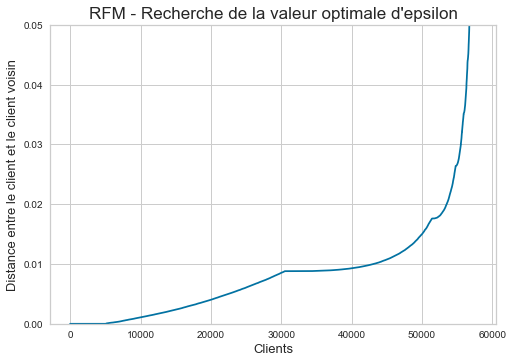

In [21]:
# Calcul des distances avec les plus proches voisins
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_rfm)
distances, indices = nbrs.kneighbors(df_rfm)

# Graphiquement
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.title("RFM - Recherche de la valeur optimale d'epsilon",
          fontsize=17)
plt.xlabel("Clients", fontsize=13)
plt.ylabel("Distance entre le client et le client voisin", fontsize=13)
plt.ylim(0, 0.05)
plt.plot(distances)

On va tester plusieurs valeurs de "*min_samples*" afin de déterminer le nombre le plus intéressant de clusters. On va mettre en avant les "*noisy samples*" à chaque fois. Les "*noisy samples*" correspondent aux points que l'on ne peut pas vraiment associer à des clusters (et que l'algorithme DBSCAN associe au cluster numéroté -1).

In [22]:
# On teste plusieurs valeurs de "min_samples"
for value in [5, 10, 15, 20, 25, 50, 100]:
    dbscan = DBSCAN(eps=0.01, min_samples=value)
    dbscan.fit(df_rfm)
    y = dbscan.fit_predict(df_rfm)

    # On regarde nos clusters
    df['cluster'] = y

    # On regarde le nombre de noisy samples
    noisy_samples = df['cluster'].value_counts()[-1]
    pourcentage = noisy_samples / df.shape[0] * 100

    print(f'Nombre de clusters (min_samples = {value}) :',
          df['cluster'].nunique())
    print('Noisy samples :', noisy_samples)
    print('En pourcentage du DataFrame:', round(pourcentage, 2), '%\n')

Nombre de clusters (min_samples = 5) : 1934
Noisy samples : 37170
En pourcentage du DataFrame: 64.47 %

Nombre de clusters (min_samples = 10) : 187
Noisy samples : 54217
En pourcentage du DataFrame: 94.04 %

Nombre de clusters (min_samples = 15) : 38
Noisy samples : 56752
En pourcentage du DataFrame: 98.43 %

Nombre de clusters (min_samples = 20) : 8
Noisy samples : 57344
En pourcentage du DataFrame: 99.46 %

Nombre de clusters (min_samples = 25) : 4
Noisy samples : 57495
En pourcentage du DataFrame: 99.72 %

Nombre de clusters (min_samples = 50) : 2
Noisy samples : 57576
En pourcentage du DataFrame: 99.86 %

Nombre de clusters (min_samples = 100) : 1
Noisy samples : 57656
En pourcentage du DataFrame: 100.0 %



On va utiliser la valeur de "*min_samples*" qui minimise le bruit, soit *min_samples = 5* ici.

In [23]:
# On choisit un "min_samples" de 5
dbscan = DBSCAN(eps=0.01, min_samples=5)
dbscan.fit(df_rfm)
y = dbscan.fit_predict(df_rfm)

# On crée notre colonne de clusters
df['cluster'] = y

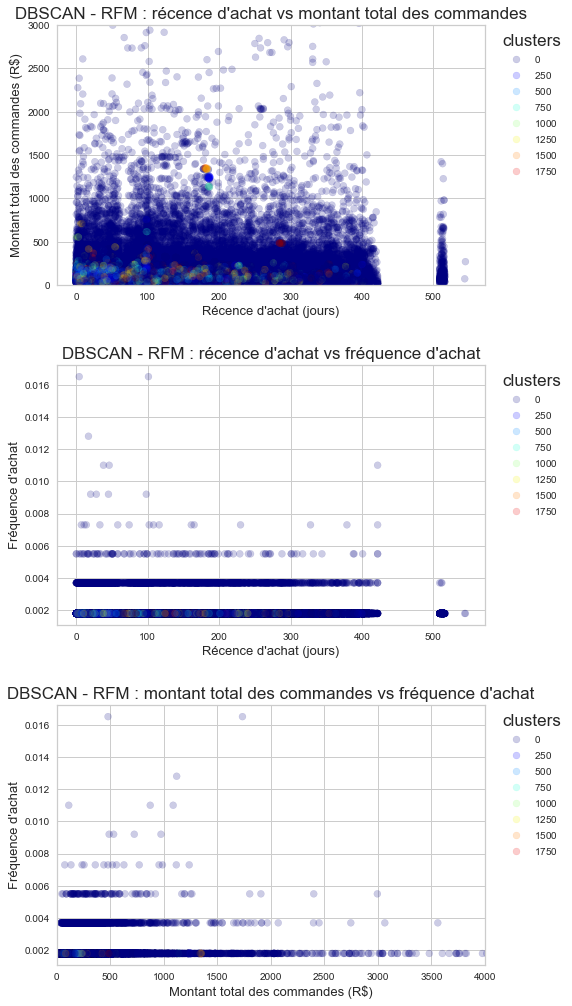

In [24]:
clusters_dbscan_rfm = dbscan.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "DBSCAN - RFM : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)

fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "DBSCAN - RFM : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: montant_total, Y: frequence_achat
ax[2].set_xlim(0, 4000)
ax[2].set_title(
    "DBSCAN - RFM : montant total des commandes vs fréquence d'achat",
    fontsize=17)
ax[2].set_xlabel("Montant total des commandes (R$)", fontsize=13)
ax[2].set_ylabel("Fréquence d'achat", fontsize=13)

fig3 = ax[2].scatter(df.iloc[:, 5], df.iloc[:, 6],
                     c=clusters_dbscan_rfm, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

## RFM - Clustering hiérarchique

On va maintenant essayer d'appliquer un clustering hiérarchique à notre jeu RFM et de visualiser les différents clusters à l'aide d'un dendrogramme.

In [25]:
# Le jeu de données est trop lourd, on ne va utiliser que 2% des données
rfm_samples = df_ini.sample(frac=.02, replace=True, random_state=24)

rfm_samples = rfm_samples[['recence', 'frequence_achat', 'montant_total']]

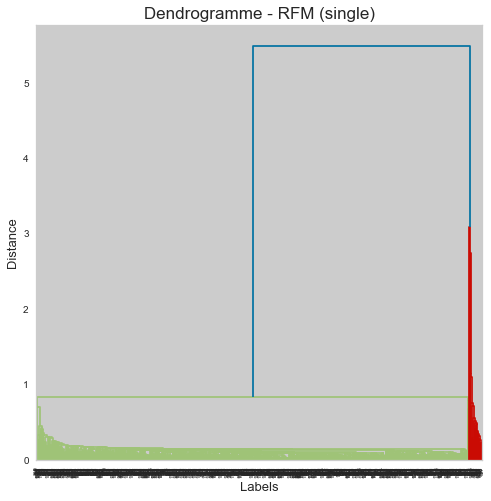

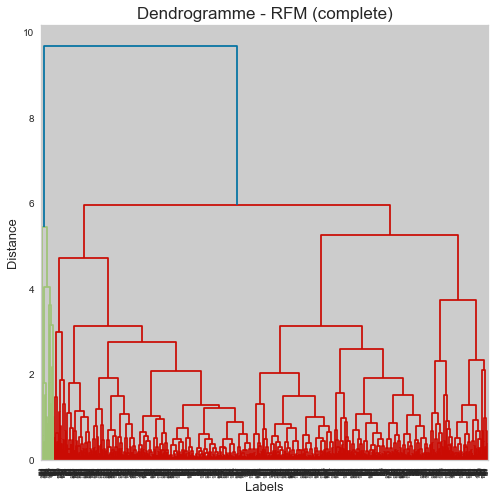

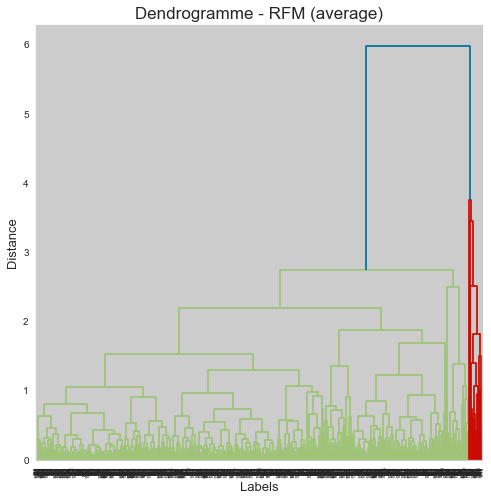

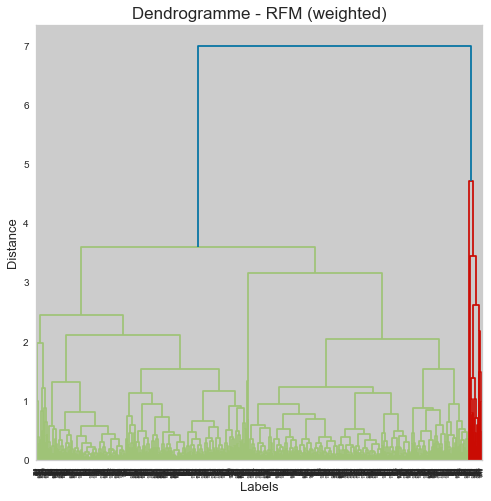

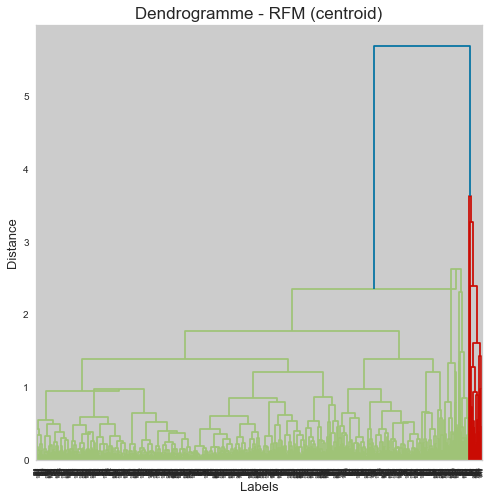

In [26]:
methods = ['single', 'complete',
           'average', 'weighted', 'centroid']

for method in methods:
    mergings_rfm = linkage(rfm_samples, method=method)

    plt.figure(figsize=(8, 8))
    plt.title(f"Dendrogramme - RFM ({method})", fontsize=17)
    plt.xlabel('Labels', fontsize=13)
    plt.ylabel('Distance', fontsize=13)
    dendrogram(mergings_rfm)
    plt.show()

# RFM avec score

On va retester nos 3 algorithmes de clustering en ajoutant une variable à notre modèle RFM : le score moyen.

## RFM avec score - k means

Encore une fois, on commence par l'algorithme de clustering du K-Means.

In [27]:
df_score = df_ini[['score_moy', 'recence', 'montant_total', 'frequence_achat']]

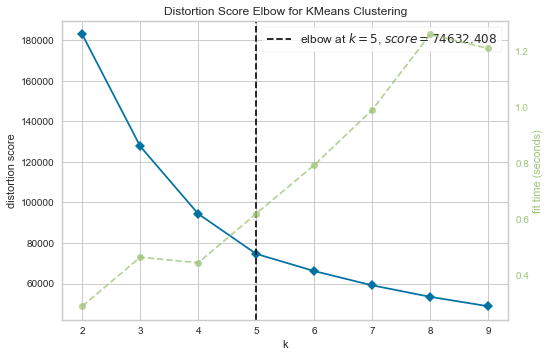

In [28]:
# Elbow plot pour déterminer le nombre optimal de cluster
elbow_k_means(df_score)

In [29]:
# On utilise notre valeur optimale de k
k_means_score = KMeans(n_clusters=5, init='k-means++',  random_state=24)

y = k_means_score.fit_predict(df_score.values)

# On regarde nos clusters
df['cluster'] = y
df['cluster'].value_counts()

1    19229
4    15167
0    12764
3     8775
2     1721
Name: cluster, dtype: int64

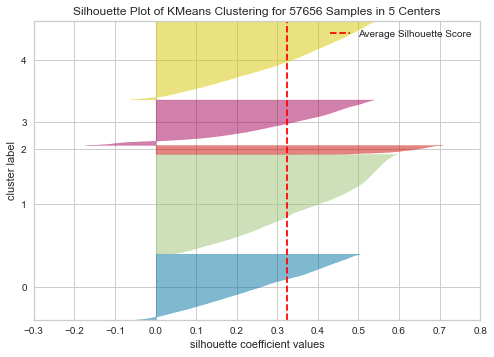

In [30]:
silhouette_k_means(df_score.values, model=k_means_score)

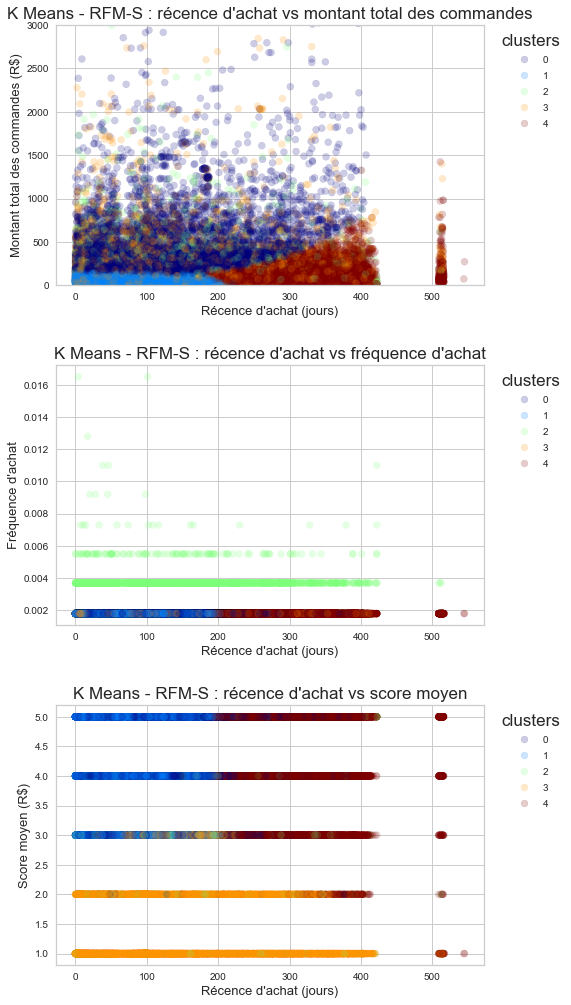

In [31]:
clusters_score = k_means_score.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "K Means - RFM-S : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "K Means - RFM-S : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: score_moy
ax[2].set_title(
    "K Means - RFM-S : récence d'achat vs score moyen",
    fontsize=17)
ax[2].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[2].set_ylabel("Score moyen (R$)", fontsize=13)
fig3 = ax[2].scatter(df.iloc[:, 4], df.iloc[:, 1],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

##  RFM avec Score - DBSCAN

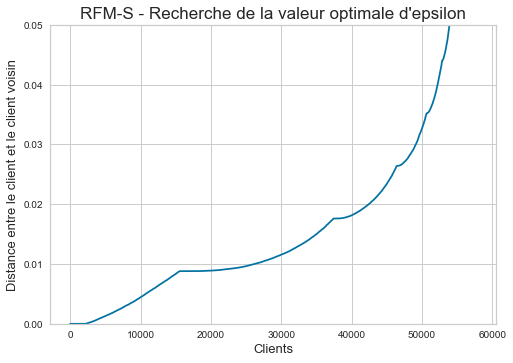

In [32]:
# Calcul des distances avec les plus proches voisins
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_score)
distances, indices = nbrs.kneighbors(df_score)

# Graphiquement
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.title("RFM-S - Recherche de la valeur optimale d'epsilon",
          fontsize=17)
plt.xlabel("Clients", fontsize=13)
plt.ylabel("Distance entre le client et le client voisin", fontsize=13)
plt.ylim(0, 0.05)
plt.plot(distances)

In [33]:
# On teste plusieurs valeurs de "min_samples"
for value in [5, 10, 15, 20, 25, 50, 100]:
    dbscan_score = DBSCAN(eps=0.02, min_samples=value)
    dbscan_score.fit(df_score)
    y_score = dbscan_score.fit_predict(df_score)

    # On regarde nos clusters
    df['cluster'] = y_score

    # On regarde le nombre de noisy samples
    noisy_samples = df['cluster'].value_counts()[-1]
    pourcentage = noisy_samples / df.shape[0] * 100

    print(f'Nombre de clusters (min_samples  = {value}) :',
          df['cluster'].nunique())
    print('Noisy samples :', noisy_samples)
    print('En pourcentage du DataFrame:', round(pourcentage, 2), '%\n')

Nombre de clusters (min_samples  = 5) : 1400
Noisy samples : 32301
En pourcentage du DataFrame: 56.02 %

Nombre de clusters (min_samples  = 10) : 344
Noisy samples : 49268
En pourcentage du DataFrame: 85.45 %

Nombre de clusters (min_samples  = 15) : 88
Noisy samples : 55139
En pourcentage du DataFrame: 95.63 %

Nombre de clusters (min_samples  = 20) : 20
Noisy samples : 56950
En pourcentage du DataFrame: 98.78 %

Nombre de clusters (min_samples  = 25) : 5
Noisy samples : 57444
En pourcentage du DataFrame: 99.63 %

Nombre de clusters (min_samples  = 50) : 2
Noisy samples : 57600
En pourcentage du DataFrame: 99.9 %

Nombre de clusters (min_samples  = 100) : 1
Noisy samples : 57656
En pourcentage du DataFrame: 100.0 %



Encore une fois, nous allons prendre un *min_samples* de 5.

In [34]:
# On choisit un "min_samples" de 5
dbscan_score = DBSCAN(eps=0.02, min_samples=5)
dbscan_score.fit(df_score)
y_score = dbscan_score.fit_predict(df_score)

# On crée notre colonne de clusters
df['cluster'] = y_score

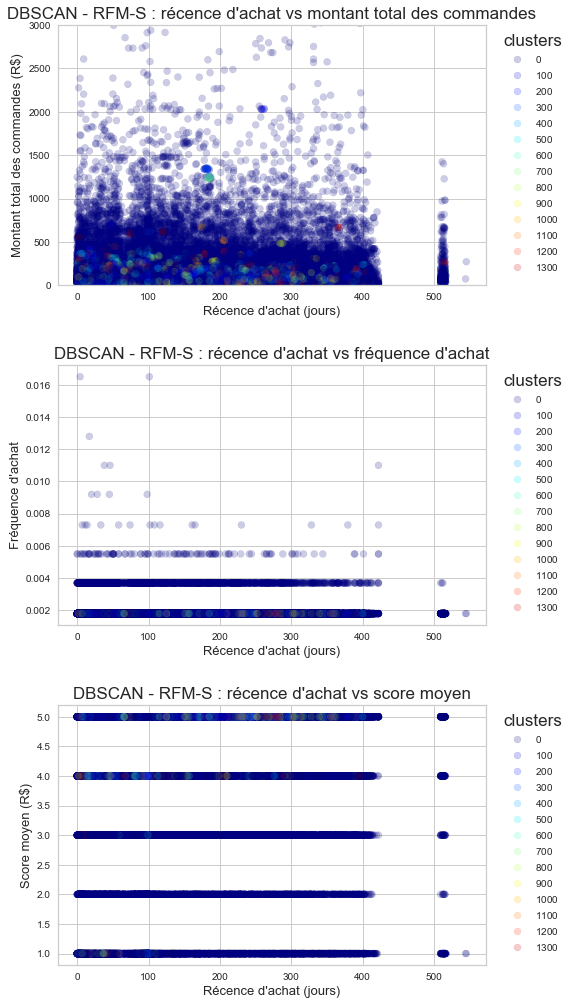

In [35]:
clusters_dbscan_score = dbscan_score.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "DBSCAN - RFM-S : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_dbscan_score, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "DBSCAN - RFM-S : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_dbscan_score, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: score_moy
ax[2].set_title(
    "DBSCAN - RFM-S : récence d'achat vs score moyen",
    fontsize=17)
ax[2].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[2].set_ylabel("Score moyen (R$)", fontsize=13)
fig3 = ax[2].scatter(df.iloc[:, 4], df.iloc[:, 1],
                     c=clusters_dbscan_score, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

##  RFM avec Score - Clustering hiérarchique

In [36]:
score_samples = df_ini.sample(frac=.02, replace=True, random_state=24)

score_samples = score_samples[['recence', 'frequence_achat',
                               'montant_total', 'score_moy']]

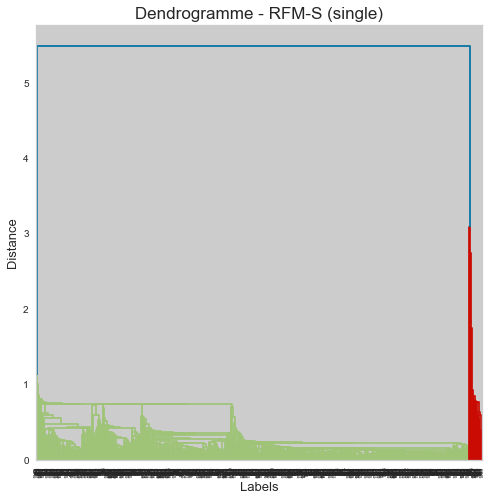

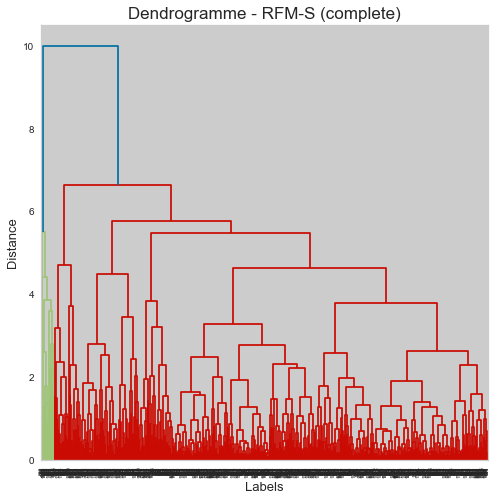

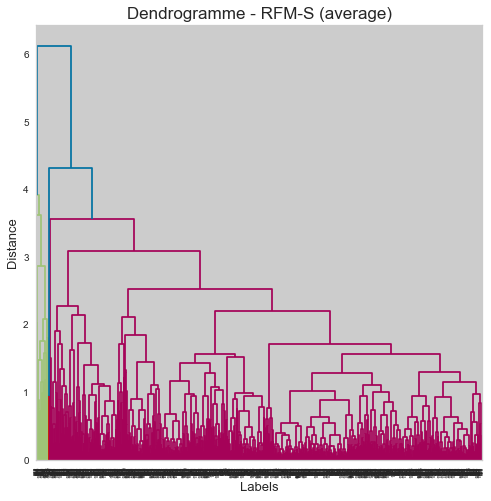

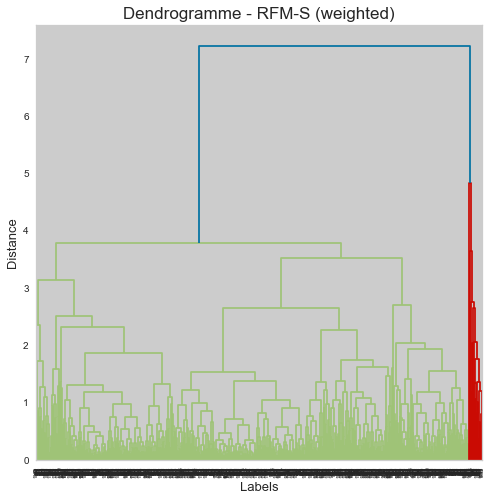

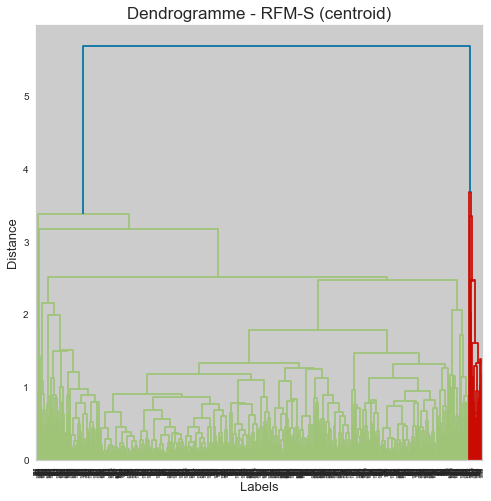

In [37]:
methods = ['single', 'complete',
           'average', 'weighted', 'centroid']

for method in methods:
    mergings_score = linkage(score_samples, method=method)

    plt.figure(figsize=(8, 8))
    plt.title(f"Dendrogramme - RFM-S ({method})", fontsize=17)
    plt.xlabel('Labels', fontsize=13)
    plt.ylabel('Distance', fontsize=13)
    dendrogram(mergings_score)
    plt.show()

# Toutes les variables

Pour notre dernier test, on va utiliser l'ensemble de nos variables : RFM, le score, le nombre de produits et de paiements par commande, etc.

## Toutes les variables - k means

Pour ce dernier test, on continue de commencer par l'algorithme du K-Means.

In [38]:
df_all = df_ini.copy()

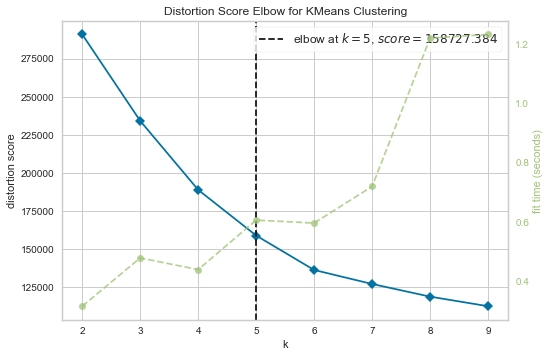

In [39]:
# Elbow plot pour déterminer le nombre optimal de cluster
elbow_k_means(df_all)

In [40]:
# On utilise notre valeur optimale de k
k_means_all = KMeans(n_clusters=5, init='k-means++',  random_state=24)
y_all_k_means = k_means_all.fit_predict(df_all.values)

# On regarde nos clusters
df['cluster'] = y_all_k_means
df['cluster'].value_counts()

3    26780
0    15661
1     8049
4     5445
2     1721
Name: cluster, dtype: int64

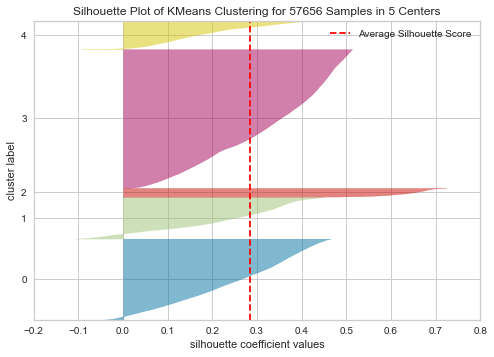

In [41]:
# Silhouette plot
silhouette_k_means(df_all.values, model=k_means_all)

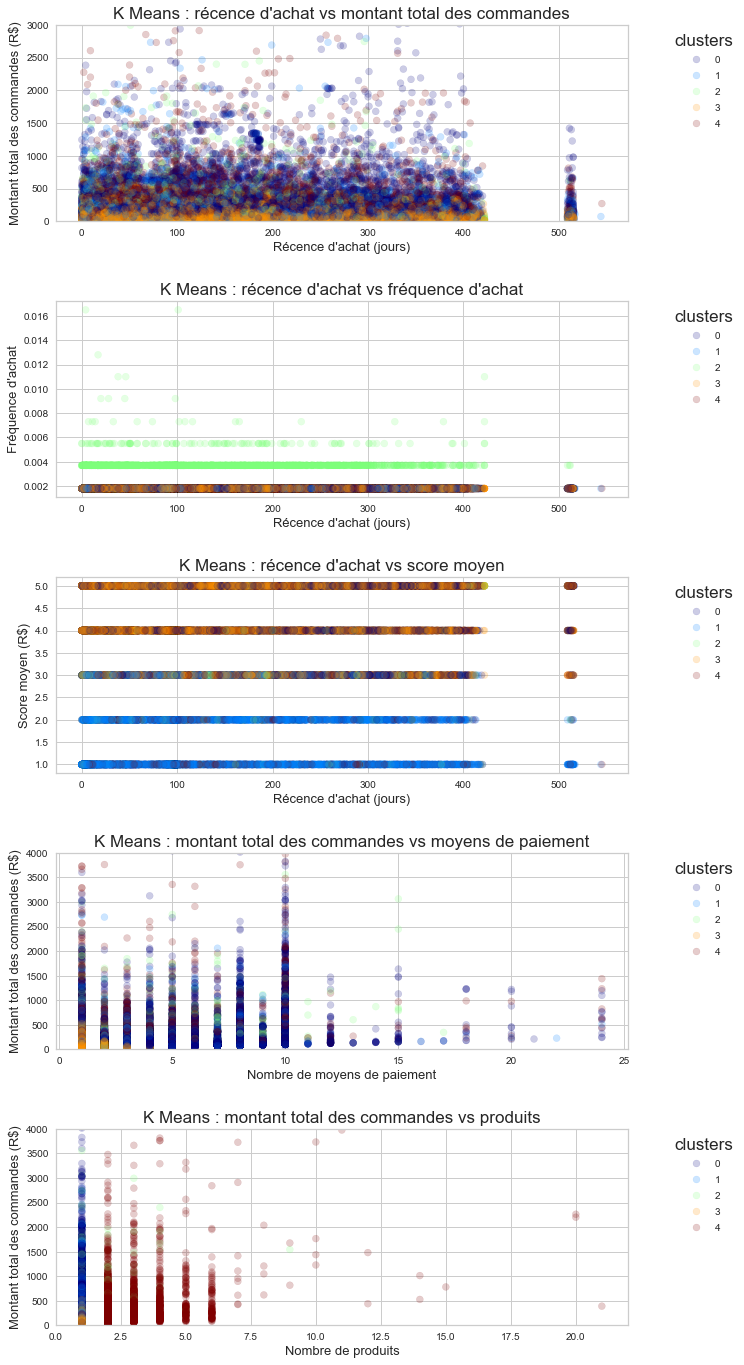

In [42]:
clusters_k_means_all = k_means_all.labels_

fig, ax = plt.subplots(5, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "K Means : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_k_means_all, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "K Means : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_k_means_all, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: score_moy
ax[2].set_title(
    "K Means : récence d'achat vs score moyen",
    fontsize=17)
ax[2].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[2].set_ylabel("Score moyen (R$)", fontsize=13)
fig3 = ax[2].scatter(df.iloc[:, 4], df.iloc[:, 1],
                     c=clusters_k_means_all, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: montant_total, Y: nb_paiements
ax[3].set_ylim(0, 4000)
ax[3].set_title(
    "K Means : montant total des commandes vs moyens de paiement",
    fontsize=17)
ax[3].set_xlabel("Nombre de moyens de paiement", fontsize=13)
ax[3].set_ylabel("Montant total des commandes (R$)",
                 fontsize=13)
fig4 = ax[3].scatter(df.iloc[:, 2], df.iloc[:, 5],
                     c=clusters_k_means_all, cmap='jet', alpha=0.2)

ax[3].legend(*fig4.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: montant_total, Y: nb_produits
ax[4].set_ylim(0, 4000)
ax[4].set_title(
    "K Means : montant total des commandes vs produits",
    fontsize=17)
ax[4].set_xlabel("Nombre de produits", fontsize=13)
ax[4].set_ylabel("Montant total des commandes (R$)",
                 fontsize=13)
fig5 = ax[4].scatter(df.iloc[:, 3], df.iloc[:, 5],
                     c=clusters_k_means_all, cmap='jet', alpha=0.2)

ax[4].legend(*fig5.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

##  Toutes les variables - DBSCAN

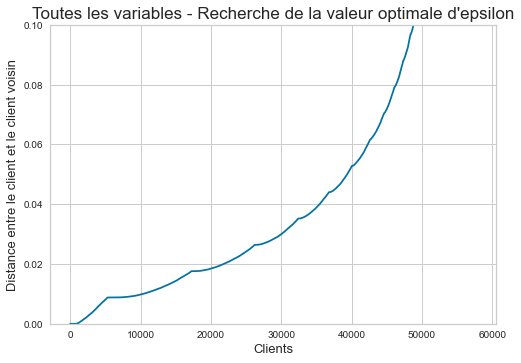

In [43]:
# Calcul des distances avec les plus proches voisins
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_all)
distances, indices = nbrs.kneighbors(df_all)

# Graphiquement
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.title("Toutes les variables - Recherche de la valeur optimale d'epsilon",
          fontsize=17)
plt.xlabel("Clients", fontsize=13)
plt.ylabel("Distance entre le client et le client voisin", fontsize=13)
plt.ylim(0, 0.10)
plt.plot(distances)

In [44]:
# On teste plusieurs valeurs de "min_samples"
for value in [5, 10, 15, 20, 25, 50, 100]:
    dbscan_all = DBSCAN(eps=0.04, min_samples=value)
    dbscan_all.fit(df_all)
    y_all_dbscan = dbscan_all.fit_predict(df_all)

    # On regarde nos clusters
    df['cluster'] = y_all_dbscan

    # On regarde le nombre de noisy samples
    noisy_samples = df['cluster'].value_counts()[-1]
    pourcentage = noisy_samples / df.shape[0] * 100

    print(f'Nombre de clusters (min_samples  = {value}) :',
          df['cluster'].nunique())
    print('Noisy samples :', noisy_samples)
    print('En pourcentage du DataFrame:', round(pourcentage, 2), '%\n')

Nombre de clusters (min_samples  = 5) : 878
Noisy samples : 37520
En pourcentage du DataFrame: 65.08 %

Nombre de clusters (min_samples  = 10) : 215
Noisy samples : 47603
En pourcentage du DataFrame: 82.56 %

Nombre de clusters (min_samples  = 15) : 92
Noisy samples : 52325
En pourcentage du DataFrame: 90.75 %

Nombre de clusters (min_samples  = 20) : 47
Noisy samples : 55034
En pourcentage du DataFrame: 95.45 %

Nombre de clusters (min_samples  = 25) : 25
Noisy samples : 56407
En pourcentage du DataFrame: 97.83 %

Nombre de clusters (min_samples  = 50) : 2
Noisy samples : 57564
En pourcentage du DataFrame: 99.84 %

Nombre de clusters (min_samples  = 100) : 1
Noisy samples : 57656
En pourcentage du DataFrame: 100.0 %



On continue avec un *min_samples* de 5 encore une fois.

In [45]:
# On choisit un "min_samples" de 5
dbscan_all = DBSCAN(eps=0.04, min_samples=5)
dbscan_all.fit(df_all)
y_all_dbscan = dbscan_all.fit_predict(df_all)

# On crée notre colonne de clusters
df['cluster'] = y_all_dbscan

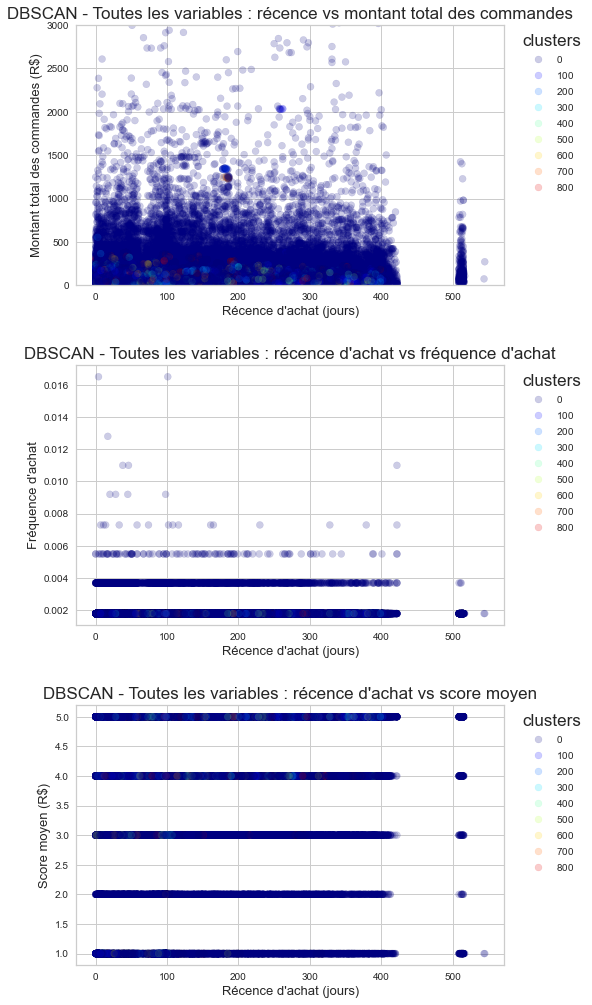

In [46]:
clusters_dbscan_all = dbscan_all.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "DBSCAN - Toutes les variables : récence vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_dbscan_all, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "DBSCAN - Toutes les variables : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_dbscan_all, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: score_moy
ax[2].set_title(
    "DBSCAN - Toutes les variables : récence d'achat vs score moyen",
    fontsize=17)
ax[2].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[2].set_ylabel("Score moyen (R$)", fontsize=13)
fig3 = ax[2].scatter(df.iloc[:, 4], df.iloc[:, 1],
                     c=clusters_dbscan_all, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

##  Toutes les variables - Clustering hiérarchique

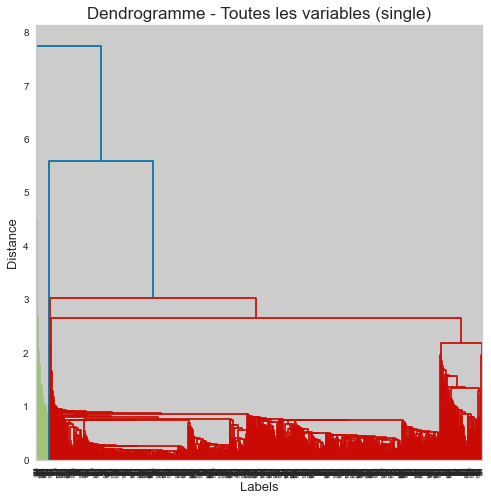

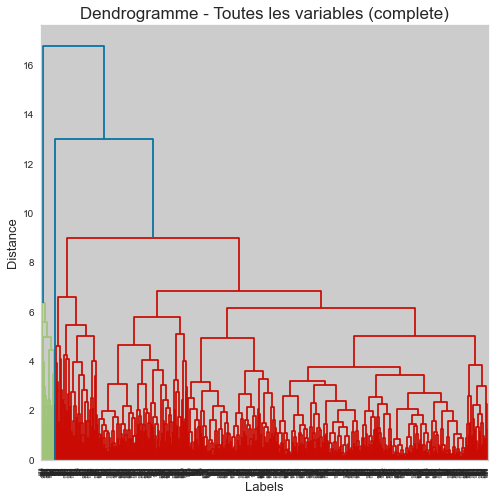

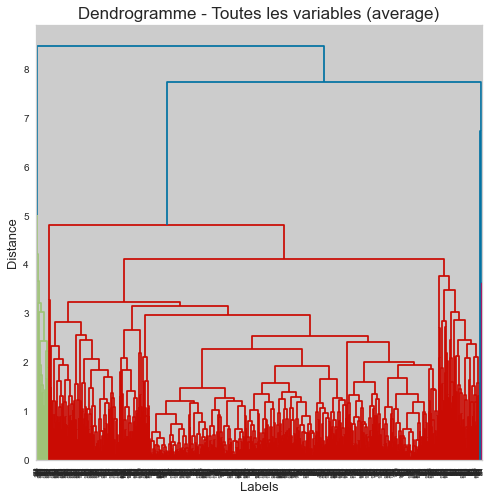

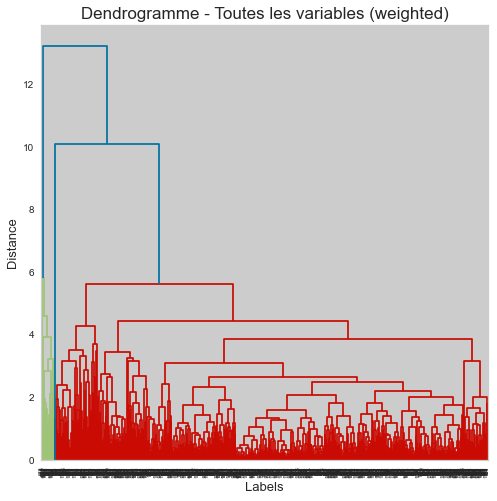

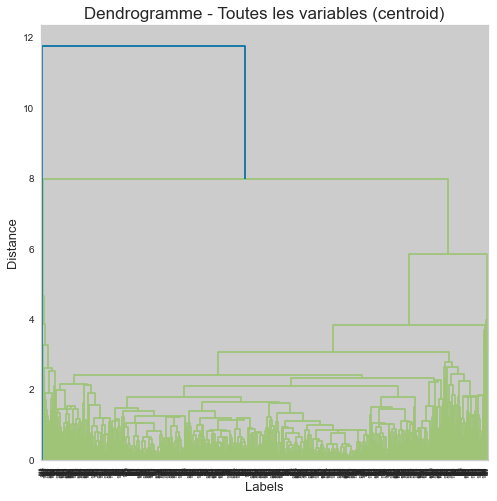

In [47]:
all_samples = df_ini.sample(frac=.02, replace=True, random_state=24)

methods = ['single', 'complete',
           'average', 'weighted', 'centroid']

for method in methods:
    mergings_all = linkage(all_samples, method=method)

    plt.figure(figsize=(8, 8))
    plt.title(f"Dendrogramme - Toutes les variables ({method})",
              fontsize=17)
    plt.xlabel('Labels', fontsize=13)
    plt.ylabel('Distance', fontsize=13)
    dendrogram(mergings_all)
    plt.show()

## Choix final

L'algorithme de clustering le plus adapté et le plus clair que nous avons pu voir est l'algorithme du K-Means pour le modèle RFM avec Score.

Nous avons 5 clusters :
- les individus qui commandent plusieurs fois,
- les individus qui donnent des mauvaises notes,
- les individus qui dépensent peu depuis moins d'un an,
- les individus qui ont peu dépensés et qui ne dépensent plus depuis plus d'un an et
- les individus qui dépensent beaucoup.

In [48]:
# On reprend nos clusters
y = k_means_score.fit_predict(df_score.values)

df['cluster'] = y

In [49]:
df['cluster'].value_counts()

1    19229
4    15167
0    12764
3     8775
2     1721
Name: cluster, dtype: int64

In [50]:
df_final = df[['recence', 'frequence_achat', 'montant_total',
               'score_moy', 'cluster']]

## Cluster 2

On a vu précédemment que l'un des clusters (numéro 2) est composé de tous les individus qui ont fait plus d'une commande sur la période étudiée. Nous allons essayer de déterminer les autres clusters.

## Cluster 3

Graphiquement, un cluster (numéro 3) semble correspondre à des mauvaises notes (1 ou 2 sur 5), vérifions :

In [51]:
df_cluster_3 = df_final[df_final['cluster'] == 3]

Regardons la répartition des notes dans ce cluster et regardons combien de clients ont donné une note inférieure à 3/5.

In [52]:
# Répartition des notes
print("Répartition des notes des individus du cluster 3 :")
print(df_cluster_3['score_moy'].value_counts(), '\n')

# Nombre de clients, note < 3
note_inf3 = df_cluster_3[df_cluster_3['score_moy'] < 3].shape[0]
print("Nombre de clients ayant donné une note inférieure à 3 :",
      note_inf3, '\n')

# En pourcentage
print("En pourcentage :", round(note_inf3 / df_cluster_3.shape[0] * 100,
                                2), "%")

Répartition des notes des individus du cluster 3 :
1    6400
2    1660
3     715
Name: score_moy, dtype: int64 

Nombre de clients ayant donné une note inférieure à 3 : 8060 

En pourcentage : 91.85 %


Nous avons donc le cluster 3 qui est composé des individus ayant donné des notes inférieures à 3.

## Clusters 0, 1 et 4

Visuellement, le cluster 0 correspond aux clients qui ont commandé pour des montants importants, le cluster 1 correspond aux clients qui ont commandé récemment et pour un montant relativement faible et le cluster 4 correspond aux clients qui ont commandé il y a moins longtemps pour des montants globalement plus faible que le cluster 0.

In [53]:
df_cluster_0 = df_final[df_final['cluster'] == 0]
df_cluster_1 = df_final[df_final['cluster'] == 1]
df_cluster_4 = df_final[df_final['cluster'] == 4]

Commençons par le cluster 1 :

In [54]:
# Petits montants, récent
df_cluster_1.describe()

,recence,frequence_achat,montant_total,score_moy,cluster
count,19229.000000,1.922900e+04,19229.000000,19229.000000,19229.0
mean,84.960112,1.800000e-03,72.309127,4.575433,1.0
std,54.948797,2.075217e-16,31.775774,0.649440,0.0
min,0.000000,1.800000e-03,6.180000,2.000000,1.0
25%,38.000000,1.800000e-03,45.090000,4.000000,1.0
50%,84.000000,1.800000e-03,67.500000,5.000000,1.0
75%,125.000000,1.800000e-03,96.320000,5.000000,1.0
max,234.000000,1.800000e-03,155.220000,5.000000,1.0


Regardons combien d'individu ont payé moins de 150$R et il y a moins de 182 jours (6 mois) :

In [55]:
# Nombre de clients
nb_clients1 = df_cluster_1[(df_cluster_1['montant_total'] <= 150) &
                           (df_cluster_1['recence'] <= 182)].shape[0]
print("Nombre de clients ayant payé moins de 150R$ récemment :",
      nb_clients1, '\n')

# En pourcentage
print("En pourcentage :", round(nb_clients1 / df_cluster_1.shape[0] * 100,
                                2), "%")

Nombre de clients ayant payé moins de 150R$ récemment : 18261 

En pourcentage : 94.97 %


Continuons avec le cluster 4 :

In [56]:
# Petits montants, moins récemment
df_cluster_4.describe()

,recence,frequence_achat,montant_total,score_moy,cluster
count,15167.000000,1.516700e+04,15167.000000,15167.000000,15167.0
mean,296.612052,1.800000e-03,111.436558,4.538406,4.0
std,66.072834,4.310930e-16,81.720962,0.721250,0.0
min,178.000000,1.800000e-03,11.920000,1.000000,4.0
25%,242.000000,1.800000e-03,57.780000,4.000000,4.0
50%,290.000000,1.800000e-03,90.320000,5.000000,4.0
75%,346.000000,1.800000e-03,139.570000,5.000000,4.0
max,545.000000,1.800000e-03,1423.550000,5.000000,4.0


In [57]:
# Nombre de clients
nb_clients4 = df_cluster_4[(df_cluster_4['montant_total'] <= 150) &
                           (df_cluster_4['recence'] > 182)].shape[0]
print("Nombre de clients ayant payé moins de 150R$ il y a au moins 6 mois :",
      nb_clients4, '\n')

# En pourcentage
print("En pourcentage :", round(nb_clients4 / df_cluster_4.shape[0] * 100,
                                2), "%")

Nombre de clients ayant payé moins de 150R$ il y a au moins 6 mois : 12012 

En pourcentage : 79.2 %


Enfin, le cluster 0 :

In [58]:
# Gros montants
df_cluster_0.describe()

,recence,frequence_achat,montant_total,score_moy,cluster
count,12764.000000,1.276400e+04,12764.000000,12764.000000,12764.0
mean,121.825603,1.800000e-03,351.698366,4.591272,0.0
std,80.093423,3.911955e-16,371.826799,0.647482,0.0
min,0.000000,1.800000e-03,122.780000,1.000000,0.0
25%,55.000000,1.800000e-03,175.770000,4.000000,0.0
50%,108.000000,1.800000e-03,231.270000,5.000000,0.0
75%,174.000000,1.800000e-03,369.600000,5.000000,0.0
max,407.000000,1.800000e-03,13664.080000,5.000000,0.0


In [59]:
# Nombre de clients
nb_clients0 = df_cluster_0[df_cluster_0['montant_total'] > 150].shape[0]
print("Nombre de clients ayant payé plus de 150R$ :",
      nb_clients0, '\n')

# En pourcentage
print("En pourcentage :", round(nb_clients0 / df_cluster_0.shape[0] * 100,
                                2), "%")

Nombre de clients ayant payé plus de 150R$ : 11667 

En pourcentage : 91.41 %


## Graphiquement :

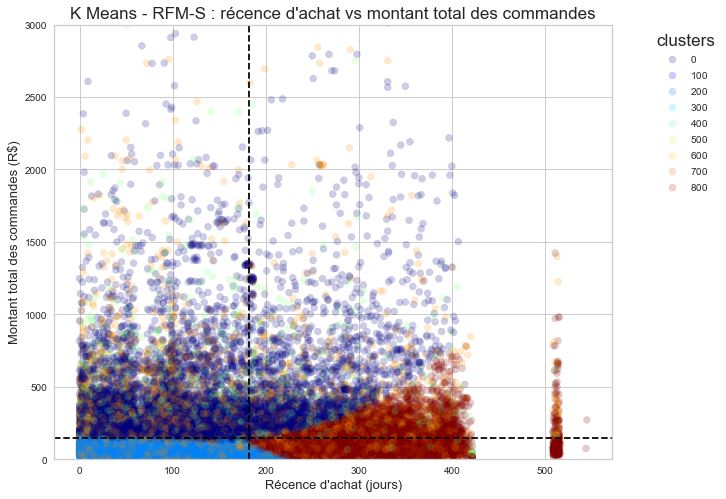

In [60]:
plt.figure(figsize=(10, 8))

plt.ylim(0, 3000)
plt.title(
    "K Means - RFM-S : récence d'achat vs montant total des commandes",
    fontsize=17)
plt.xlabel("Récence d'achat (jours)", fontsize=13)
plt.ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = plt.scatter(df.iloc[:, 4], df.iloc[:, 5],
                   c=clusters_score, cmap='jet', alpha=0.2)
plt.axhline(y=150, color='black', linestyle='--')
plt.axvline(x=182, color='black', linestyle='--')

plt.legend(*fig2.legend_elements(), title='clusters',
           bbox_to_anchor=(1.2, 1), title_fontsize=17)